# order_reviews_dataset

### Key Columns:
- *review_creation_answer_time_hours*
- *review_score_extended*

### Foreign Keys:
- *order_id* -> **order_items_dataset** AND **order_payments_dataset**
- *customer_id* -> **order_customer_dataset**

### Key Findings:
- the majority of the customers leaving their reviews **without any comments** give 5-stars, in particular:
    - $1$⭐ : $4.60$%
    - $2$⭐⭐ : $1.73$%
    - $3$⭐⭐⭐ : $7.94$%
    - $4$⭐⭐⭐⭐ : $22.60$%
    - $5$⭐⭐⭐⭐⭐ : $63.13$%
- **customers who left the comment** are less decisive but half of them are actually very happy about the product. The percentages look this way:
    - $1$⭐ : $21.34$%
    - $2$⭐⭐ : $5.24$%
    - $3$⭐⭐⭐ : $8.68$%
    - $4$⭐⭐⭐⭐ : $14.58$%
    - $5$⭐⭐⭐⭐⭐ : $50.16$%
- *review_score* and *extended_review_score* are actually the same in terms of correlatation. The *review_creation* answer time is not correlated with the *review_score* and *extended_review_score* whatsoever though (at least linearly)
- we can probably conclude that on average the worse reviewed items get the answers faster, while the average time for $5$ and $6$ stars is the longest (chart below)

### Preprocessing steps:

- change types of *review_creation_date* and *review_answer_timestamp* to datetime
- create new column - *creation_answer_time* to specify the time elapsed from creating the review to receiving an answer (*review_creation_date* - *review_answer_timestamp*)
- create new column *review_score_extended*, if the *review_score* is $1$ or $5$ and there is the comment, then we extend this score to either $0$ or $6$. The motivation is that if the customer spent its own time to leave the comment, then he/she should be given a new category: either $6$ - overjoyed or $0$ - extremely unhappy about the product.
- remove outliers from *review_creation_answer_time_hours* after preprocessing

$6.35\%$ of data has been removed.

## EDA

In [ ]:
from utils import check_functions, visuals, cleaning, preprocessing, feature_engineering

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_colwidth', None)

In [ ]:
order_reviews_dataset = pd.read_csv('../data/raw/order_reviews_dataset.csv')
order_reviews_dataset

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super recomendo essa loja!",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [4]:
order_reviews_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [5]:
check_functions.missing_values(order_reviews_dataset)

,Column,Missing Values
0,review_id,0
1,order_id,0
2,review_score,0
3,review_comment_title,87656
4,review_comment_message,58247
5,review_creation_date,0
6,review_answer_timestamp,0


In [6]:
check_functions.nunique_values(order_reviews_dataset)

,Column,Nunique,Unique Values
0,review_id,98410,Too Much
1,order_id,98673,Too Much
2,review_score,5,"[4, 5, 1, 3, 2]"
3,review_comment_title,4527,Too Much
4,review_comment_message,36159,Too Much
5,review_creation_date,636,Too Much
6,review_answer_timestamp,98248,Too Much


In [7]:
check_functions.duplicates(order_reviews_dataset)

There are no duplicates.


In [8]:
numerical_summary, object_summary = check_functions.summarize(order_reviews_dataset)

In [9]:
numerical_summary

,count,mean,std,min,25%,50%,75%,max
review_score,99224.0,4.086421,1.347579,1.0,4.0,5.0,5.0,5.0


In [10]:
object_summary

,count,unique,top,freq
review_id,99224,98410,7b606b0d57b078384f0b58eac1d41d78,3
order_id,99224,98673,c88b1d1b157a9999ce368f218a407141,3
review_comment_title,11568,4527,Recomendo,423
review_comment_message,40977,36159,Muito bom,230
review_creation_date,99224,636,2017-12-19 00:00:00,463
review_answer_timestamp,99224,98248,2017-06-15 23:21:05,4


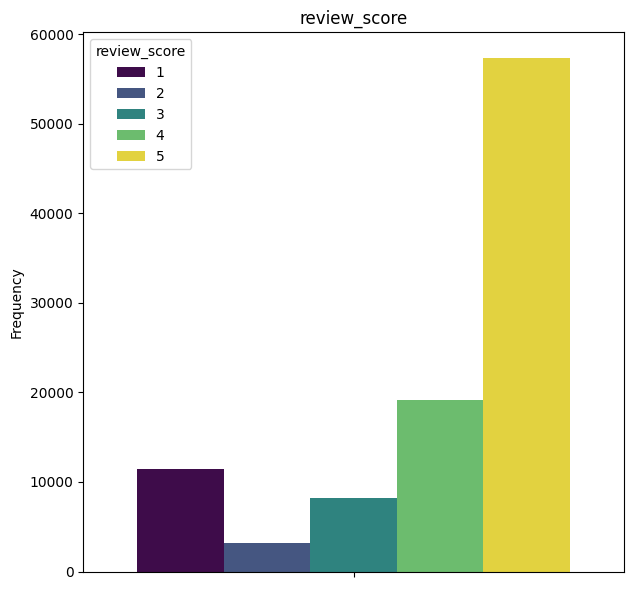

In [11]:
visuals.barplots(order_reviews_dataset, ['review_score'])

In [12]:
# Reviews with no comments
no_comments = order_reviews_dataset[order_reviews_dataset['review_comment_message'].isna()]

Actually, almost **60%** of reviewers left only the score without any comment. Let's see if the distribution is still similar to the one from the original data.

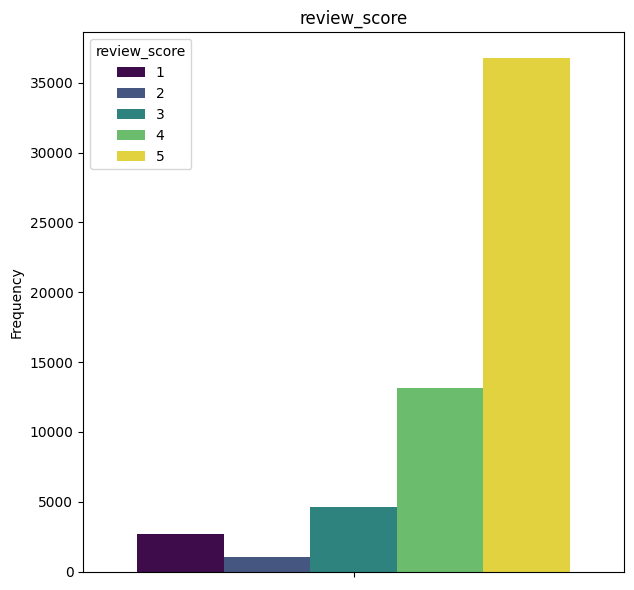

In [13]:
visuals.barplots(no_comments, ['review_score'])

The majority of the customers leaving their reviews **without any comments** give 5-stars, in particular:
- $1$⭐ : $4.60$%
- $2$⭐⭐ : $1.73$%
- $3$⭐⭐⭐ : $7.94$%
- $4$⭐⭐⭐⭐ : $22.60$%
- $5$⭐⭐⭐⭐⭐ : $63.13$%

What about those who left the comment?

In [14]:
# Reviews with comments (possibly without a title)
with_comments = order_reviews_dataset[order_reviews_dataset['review_comment_message'].notna()]

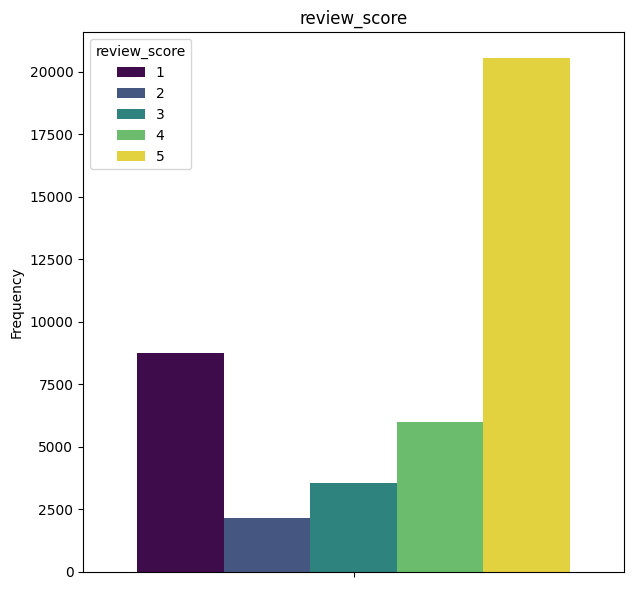

In [15]:
visuals.barplots(with_comments, ['review_score'])

The **customers who left the comment** are less decisive but half of them are actually very happy about the product. The percentages look this way:
- $1$⭐ : $21.34$%
- $2$⭐⭐ : $5.24$%
- $3$⭐⭐⭐ : $8.68$%
- $4$⭐⭐⭐⭐ : $14.58$%
- $5$⭐⭐⭐⭐⭐ : $50.16$%

## Data Preprocessing & Feature Engineering

1. First, we need to change the types of *review_creation_date* and *review_answer_timestamp* to datetime.
2. We intend to create the new column *creation_answer_time* to specify the time elapsed from creating the review to receiving an answer (*review_creation_date* - *review_answer_timestamp*). 
3. Additionally, we create the column *review_score_extended*, if the *review_score* is $1$ or $5$ and there is the comment, then we extend this score to either $0$ or $6$. The motivation is that if the customer spent its own time to leave the comment, then he/she should be given a new category: either $6$ - overjoyed or $0$ - extremely unhappy about the product.

In [ ]:
def review_score_ext(X):
    X['review_score_extended'] = X['review_score']
    
    condition = X['review_comment_message'].notna()
    X.loc[condition & (X['review_score'] == 1), 'review_score_extended'] -= 1
    X.loc[condition & (X['review_score'] == 5), 'review_score_extended'] += 1
    
    return X['review_score_extended']

In [17]:
pipeline = make_pipeline(
    preprocessing.DataTypeTransformer({"review_creation_date": "datetime64[ns]", "review_answer_timestamp": "datetime64[ns]"}),
    feature_engineering.FeatureAdder("review_creation_answer_time_hours", 
                                     lambda X: (X['review_answer_timestamp'] - X['review_creation_date']).dt.total_seconds() / 3600),
    feature_engineering.FeatureAdder("review_score_extended", review_score_ext)
)

In [18]:
order_reviews_dataset_final = pipeline.fit_transform(order_reviews_dataset)
order_reviews_dataset_final

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_creation_answer_time_hours,review_score_extended
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59,21.783056,4
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13,27.086944,5
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24,38.606667,5
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,22.035000,6
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,2018-03-01,2018-03-02 10:26:53,34.448056,6
...,...,...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07,2018-07-14 17:18:30,185.308333,5
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09,2017-12-11 20:06:42,68.111667,5
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super recomendo essa loja!",2018-03-22,2018-03-23 09:10:43,33.178611,6
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01,2018-07-02 12:59:13,36.986944,4


## EDA After Feature Engineering

In [19]:
order_reviews_dataset_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   review_id                          99224 non-null  object        
 1   order_id                           99224 non-null  object        
 2   review_score                       99224 non-null  int64         
 3   review_comment_title               11568 non-null  object        
 4   review_comment_message             40977 non-null  object        
 5   review_creation_date               99224 non-null  datetime64[ns]
 6   review_answer_timestamp            99224 non-null  datetime64[ns]
 7   review_creation_answer_time_hours  99224 non-null  float64       
 8   review_score_extended              99224 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 6.8+ MB


In [20]:
numerical_summary_final, object_summary_final = check_functions.summarize(order_reviews_dataset_final)

In [21]:
numerical_summary_final

,count,mean,min,25%,50%,75%,max,std
review_score,99224.0,4.086421,1.0,4.0,5.0,5.0,5.0,1.347579
review_creation_date,99224,2018-01-12 20:49:23.948238336,2016-10-02 00:00:00,2017-09-23 00:00:00,2018-02-02 00:00:00,2018-05-16 00:00:00,2018-08-31 00:00:00,NaN
review_answer_timestamp,99224,2018-01-16 00:23:56.977938688,2016-10-07 18:32:28,2017-09-27 01:53:27.249999872,2018-02-04 22:41:47.500000,2018-05-20 12:11:21.500000,2018-10-29 12:27:35,NaN
review_creation_answer_time_hours,99224.0,75.575842,2.141389,24.116875,40.19875,74.485556,12448.781111,237.361183
review_score_extended,99224.0,4.205434,0.0,4.0,5.0,5.0,6.0,1.737707


In [22]:
object_summary_final

,count,unique,top,freq
review_id,99224,98410,7b606b0d57b078384f0b58eac1d41d78,3
order_id,99224,98673,c88b1d1b157a9999ce368f218a407141,3
review_comment_title,11568,4527,Recomendo,423
review_comment_message,40977,36159,Muito bom,230


Let's compare *review_score* and *review_score_extended*:

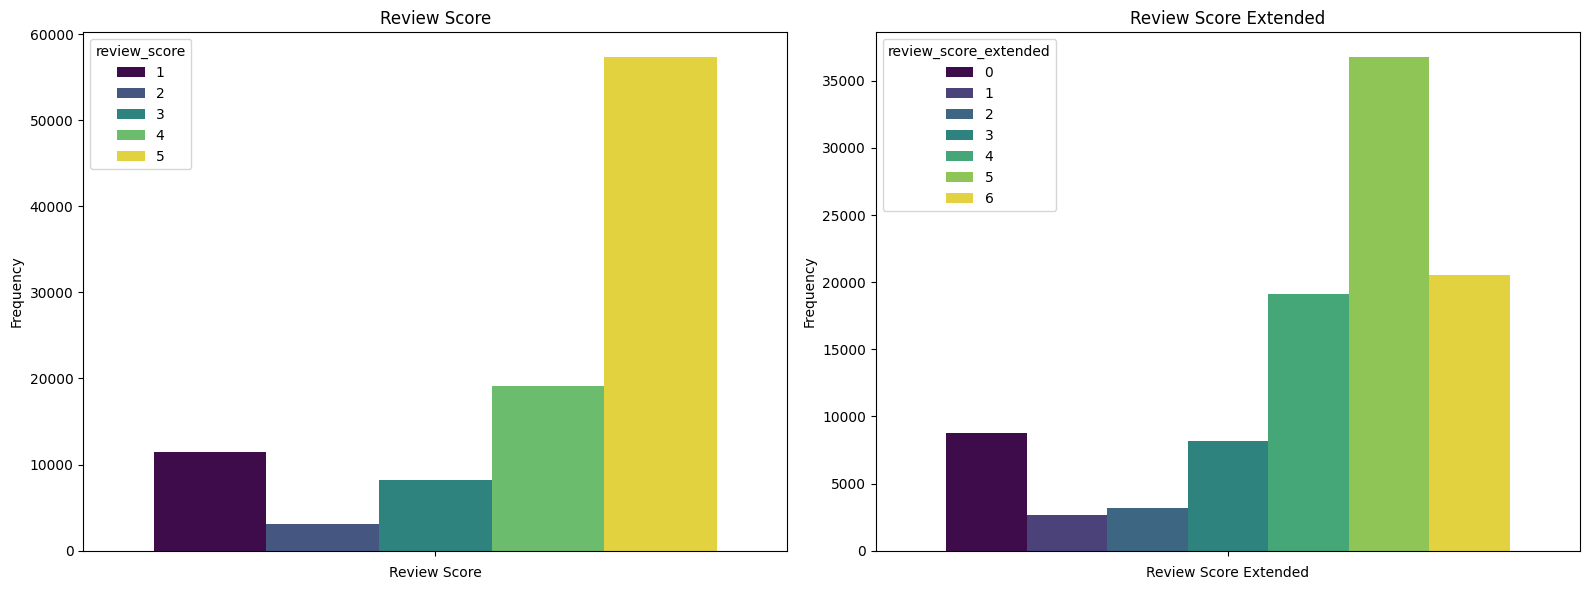

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

review_score_counts = order_reviews_dataset['review_score'].value_counts()
sns.barplot(
    hue=review_score_counts.index,
    y=review_score_counts.values,
    ax=axes[0],
    palette="viridis"
)
axes[0].set_title('Review Score')
axes[0].set_xlabel('Review Score')
axes[0].set_ylabel('Frequency')

review_score_extended_counts = order_reviews_dataset_final['review_score_extended'].value_counts()
sns.barplot(
    hue=review_score_extended_counts.index,
    y=review_score_extended_counts.values,
    ax=axes[1],
    palette="viridis"
)
axes[1].set_title('Review Score Extended')
axes[1].set_xlabel('Review Score Extended')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Hopefully, *review_score_extended* will provide a better insight into the data, as it uses the fact whether the customer left the comment or not to adjust the column values.

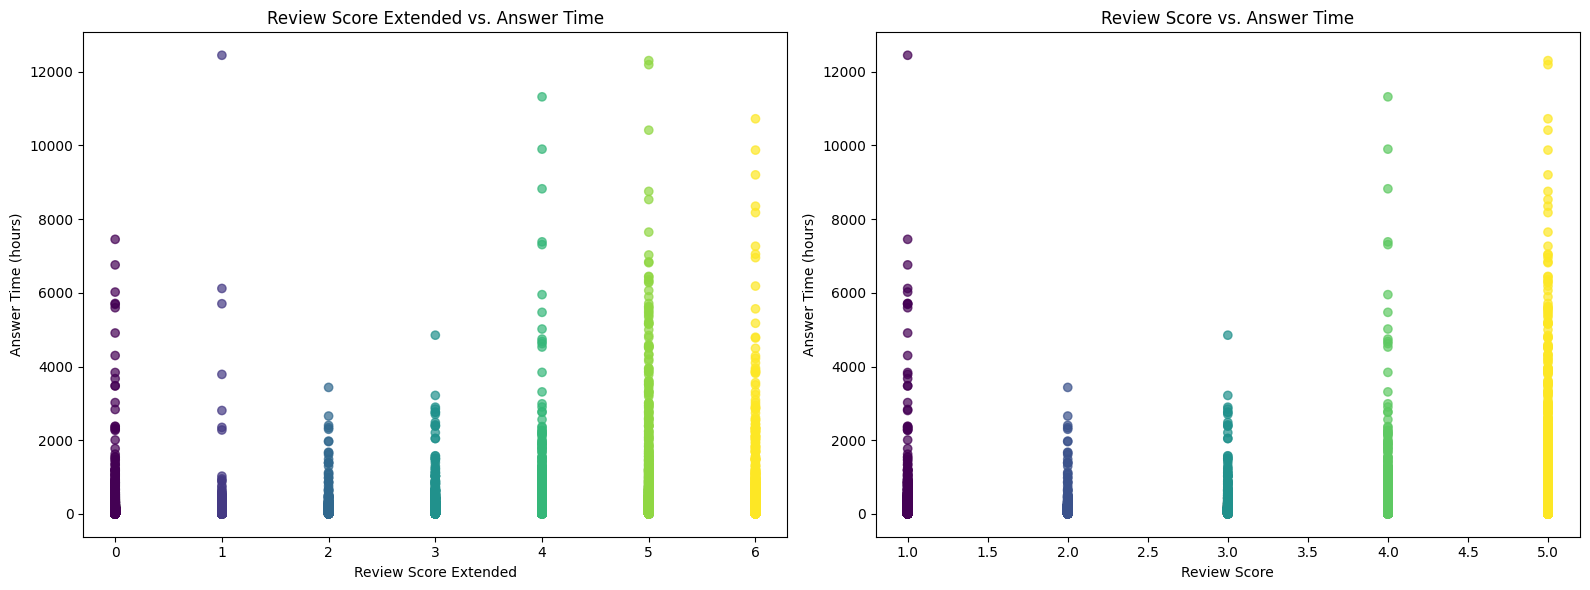

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sc1 = axes[0].scatter(
    x=order_reviews_dataset_final["review_score_extended"],
    y=order_reviews_dataset_final["review_creation_answer_time_hours"],
    c=order_reviews_dataset_final["review_score_extended"],
    cmap="viridis",
    alpha=0.7,
)
axes[0].set_title("Review Score Extended vs. Answer Time")
axes[0].set_xlabel("Review Score Extended")
axes[0].set_ylabel("Answer Time (hours)")

sc2 = axes[1].scatter(
    x=order_reviews_dataset["review_score"],
    y=order_reviews_dataset_final["review_creation_answer_time_hours"],
    c=order_reviews_dataset["review_score"],
    cmap="viridis",
    alpha=0.7
)
axes[1].set_title("Review Score vs. Answer Time")
axes[1].set_xlabel("Review Score")
axes[1].set_ylabel("Answer Time (hours)")

plt.tight_layout()
plt.show()


We can probably conclude that on average the worse reviewed items get the answers faster, while the average time for $5$ and $6$ stars is the longest.

Let's also have a look at the correlations after the new columns were added:

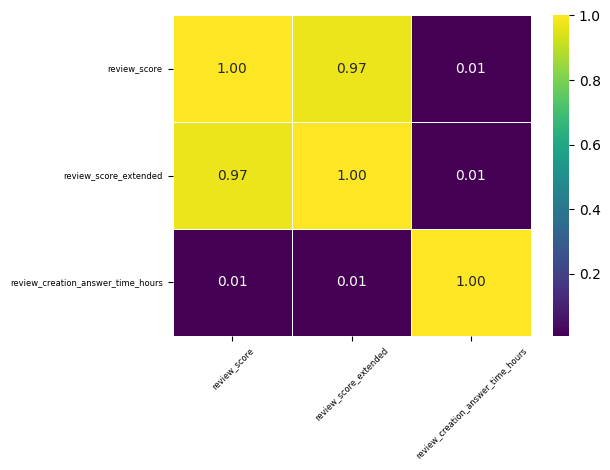

In [25]:
visuals.correlations(order_reviews_dataset_final, ['review_score', 'review_score_extended', 'review_creation_answer_time_hours'])

Well, no surpise here. The *review_score* and the *extended_review_score* are actually the same in terms of correlatation. The *review_creation* answer time is not correlated with the *review_score* and *extended_review_score* whatsoever though (at least linearly).

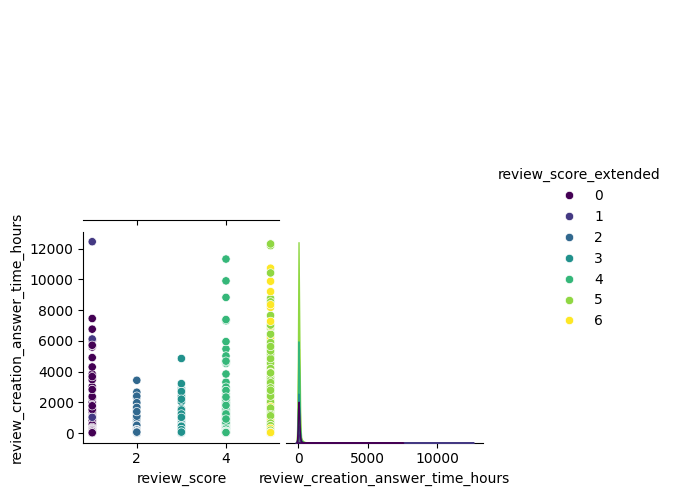

In [26]:
visuals.pairplots(order_reviews_dataset_final, ['review_score', 'review_score_extended', 'review_creation_answer_time_hours'], hue='review_score_extended')

There are outliers in the *review_creation_answer_time_hours* but we are not sure whether to dispose of them.

In [27]:
check_functions.outliers(order_reviews_dataset_final, ['review_creation_answer_time_hours'])

,Outlier Count,Outlier Percentage (%)
Column,,
review_creation_answer_time_hours,6305,6.354309


We still do not know whether it would be reasonable to remove this $6305$ so let us look at them:

c:\Users\jk200\Desktop\Ehhh\Coding\Machine Learning\Project2\eda\eda_utils\visuals.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=dataset, x=column, kde=True, ax=axes[i], palette=sns.color_palette("viridis", as_cmap=True))


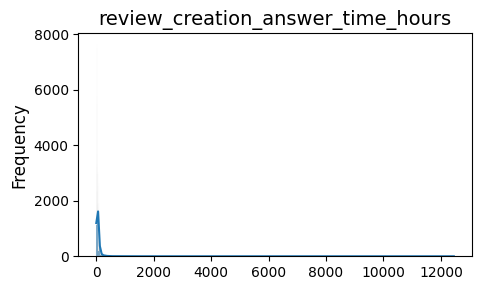

In [28]:
visuals.histograms(order_reviews_dataset_final, ['review_creation_answer_time_hours'])

We conclude that the review_creation_answer_time_hours feature outliers can be removed as they are not significant in number but their values may overshadow the majority that is closer to 0.

In [29]:
pipeline2 = make_pipeline(
    cleaning.OutlierRemover_IQR(columns=['review_creation_answer_time_hours'])
)

In [30]:
order_reviews_dataset_final_final = pipeline2.fit_transform(order_reviews_dataset_final)
order_reviews_dataset_final_final

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_creation_answer_time_hours,review_score_extended
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59,21.783056,4
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13,27.086944,5
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24,38.606667,5
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,22.035000,6
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,2018-03-01,2018-03-02 10:26:53,34.448056,6
...,...,...,...,...,...,...,...,...,...
99218,af2dc0519de6e0720ef0c74292fb4114,d699c734a0b1c8111f2272a3f36d398c,5,NaN,NaN,2018-04-27,2018-04-30 01:18:57,73.315833,5
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09,2017-12-11 20:06:42,68.111667,5
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super recomendo essa loja!",2018-03-22,2018-03-23 09:10:43,33.178611,6
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01,2018-07-02 12:59:13,36.986944,4


c:\Users\jk200\Desktop\Ehhh\Coding\Machine Learning\Project2\eda\eda_utils\visuals.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=dataset, x=column, kde=True, ax=axes[i], palette=sns.color_palette("viridis", as_cmap=True))


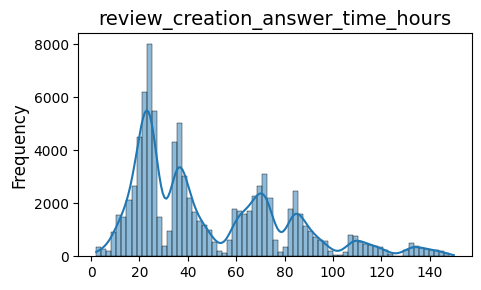

In [31]:
visuals.histograms(order_reviews_dataset_final_final, ['review_creation_answer_time_hours'])

Now, it looks more reasonable.

In [ ]:
# order_reviews_dataset_final_final.to_csv("../data/after/order_reviews_dataset_done.csv")